## OpenCV Integration Example
Note: SwiftCV package requires OpenCV installed in order to compile.

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SwiftCV")' SwiftCV
%install '.package(path: "$cwd/FastaiNotebook_08_data_block")' FastaiNotebook_08_data_block

Installing packages:
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/FastaiNotebook_08_data_block")
		FastaiNotebook_08_data_block
With SwiftPM flags: []
Working in: /tmp/tmpjbhezmb1/swift-install
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/bin/swiftc)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by

### Imports

In [ ]:
%include "EnableIPythonDisplay.swift"
import Foundation
import Python
import TensorFlow
import SwiftCV
import Path

let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
import FastaiNotebook_08_data_block

In [ ]:
// display opencv version
print(cvVersion())

4.1.0


In [ ]:
func show_img(_ img: Mat, _ w: Int = 7, _ h: Int = 5) {
    show_img(Tensor<UInt8>(cvMat: img)!, w, h)
}

func show_img<T:NumpyScalarCompatible>(_ img: Tensor<T>, _ w: Int = 7, _ h: Int = 5) {
    show_img(img.makeNumpyArray(), w, h)
}

func show_img(_ img: PythonObject, _ w: Int = 7, _ h: Int = 5) {
    plt.figure(figsize: [w, h])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
}

### Load image

In [ ]:
func readImage(_ path:String)->Mat {
    let cvImg = imread(path)
    return cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [ ]:
let path = downloadImagenette(sz:"")
let allNames = fetchFiles(path: path/"train/n03425413", recurse: false, extensions: ["jpeg", "jpg"])
let fNames = Array(allNames[0..<256])
let ns = fNames.map {$0.string}
let imgpath = ns[0]
var cvImg = readImage(imgpath)

### Timing

In [ ]:
cvImg.size

▿ 2 elements
  - 0 : 333
  - 1 : 500


In [ ]:
time(repeating:10) {_ = readImage(imgpath)}

average: 3.5929432000000006 ms,   min: 3.528081 ms,   max: 3.827633 ms


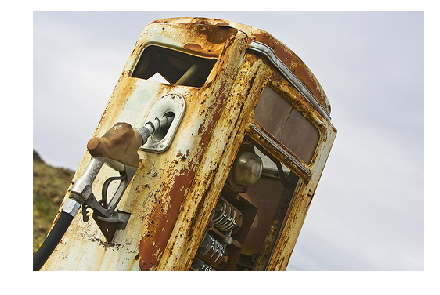

In [ ]:
show_img(cvImg)

In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_NEAREST)}

average: 0.10642460000000001 ms,   min: 0.10587 ms,   max: 0.107419 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_LINEAR)}

average: 0.5430235 ms,   min: 0.540937 ms,   max: 0.553827 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_CUBIC)}

average: 0.5534472 ms,   min: 0.550642 ms,   max: 0.5612 ms


In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_AREA)}

average: 2.0181585 ms,   min: 2.009671 ms,   max: 2.034208 ms


In [ ]:
cvImg = resize(cvImg, nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_CUBIC)

In [ ]:
func readResized(_ fn:String)->Mat {
    return resize(readImage(fn), nil, Size(224, 224), 0, 0, InterpolationFlag.INTER_AREA)
}

In [ ]:
var imgs = ns[0..<10].map(readResized)

In [ ]:
public protocol Countable {
    var count:Int {get}
}
extension Mat  :Countable {}
extension Array:Countable {}

public extension Sequence where Element:Countable {
    var totalCount:Int { return map({ $0.count }).reduce(0, +) }
}

In [ ]:
func collateMats(_ imgs:[Mat])->Tensor<Float> {
    let c = imgs.totalCount
    let ptr = UnsafeMutableRawPointer.allocate(byteCount: c, alignment: 1)
    defer {ptr.deallocate()}
    var p = ptr
    for img in imgs {
        p.copyMemory(from: img.dataPtr, byteCount: img.count)
        p = p.advanced(by: img.count)
    }
    let r = UnsafeBufferPointer(start: ptr.bindMemory(to: UInt8.self, capacity: c), count: c)
    cvImg = imgs[0]
    let shape = TensorShape([imgs.count, cvImg.rows, cvImg.cols, cvImg.channels])
    let res = Tensor(shape: shape, scalars: r)
    return Tensor<Float>(res)/255.0
}

In [ ]:
var t = collateMats(imgs)

In [ ]:
t.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 10
    - 1 : 224
    - 2 : 224
    - 3 : 3


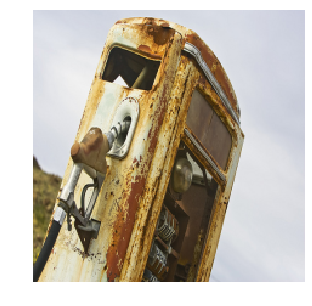

In [ ]:
show_img(t[0])

In [ ]:
time(repeating:10) {_ = collateMats(imgs)}

average: 0.8354361000000001 ms,   min: 0.785687 ms,   max: 1.145824 ms


In [ ]:
time { _ = ns.map(readResized) }

average: 2012.155474 ms,   min: 2012.155474 ms,   max: 2012.155474 ms


### Threading

In [ ]:
SetNumThreads(1)

In [ ]:
func f()->Array<SwiftCV.Mat?> {
    var result = Array<SwiftCV.Mat?>(repeating: nil, count: fNames.count)
    let q = DispatchQueue(label: "lockQueue") // , qos: .userInteractive, attributes: .concurrent)
    let c = fNames.count
    DispatchQueue.concurrentPerform(iterations: 9) {
        i in
        let s = c/10
        let min = i*s
        let max = min+s >= c ? c : min+s
        for idx in min..<max {
            let element = q.sync { ns[idx] }
//             q.sync {print(element)}
//             let transformed = q.sync {Image_IMRead(element, IMReadMode.IMREAD_COLOR.rawValue)}
            let transformed = q.sync {readResized(element)}
//             q.sync {let transformed = im(element)}
            q.sync { result[idx] = transformed }
        }
    }
    return result
}

In [ ]:
let result = f()

: 

In [ ]:
result[100]

: 

In [ ]:
print(result[230])

: 

In [ ]:
public func pmap() -> [Mat?] {
    let c = fNames.count
    var res = [Mat?](repeating: nil, count: c)

    let q = OperationQueue()
    let operations = ns.enumerated().map { i, fn in
        return BlockOperation {
//             let transformed = q.underlyingQueue?.sync { readResized(fn) }
//             q.underlyingQueue?.sync { res[i] = transformed }
        }
    }
    q.addOperations(operations, waitUntilFinished: true)
    return res
}

In [ ]:
let oq = OperationQueue()

In [ ]:
oq.maxConcurrentOperationCount

In [ ]:
let result = pmap()

: 

In [ ]:
extension Array {
    func concurrentMap<B>(_ transform: @escaping (Element) -> B) -> [B] {
        var result = Array<B?>(repeating: nil, count: count)
        let q = DispatchQueue(label: "sync queue")
        q.async()
        DispatchQueue.concurrentPerform(iterations: count) { idx in
            let element = self[idx]
            let transformed = transform(element)
            q.sync { result[idx] = transformed }
        }
        return result.map { $0! }
    }
}

: 

In [ ]:
print(result[1])

nil


In [ ]:
let im2 = fNames.map(readResized)

: 

In [ ]:
let im2 = fNames.concurrentMap(readResized)

: 

### OpenCV Transformations

#### Resize

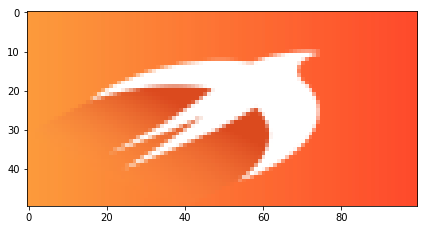

In [ ]:
show_img(
    resize(cvImg, nil, Size(100, 50), 0, 0, InterpolationFlag.INTER_AREA)
)

#### Zoom / Crop

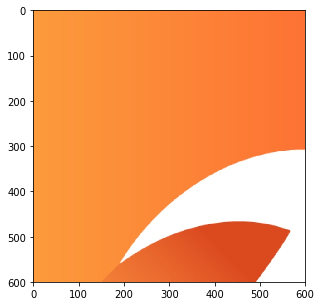

In [ ]:
let zoomMat = getRotationMatrix2D(Size(cvImg.cols, cvImg.rows / 2), 0, 1)
show_img(
    warpAffine(cvImg, nil, zoomMat, Size(600, 600))
)

#### Rotate

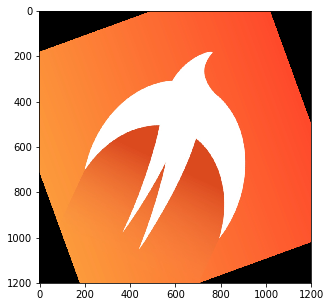

In [ ]:
let rotMat = getRotationMatrix2D(Size(cvImg.cols / 2, cvImg.rows / 2), 20, 1)
show_img(
    warpAffine(cvImg, nil, rotMat, Size(cvImg.cols, cvImg.rows))
)

#### Pad

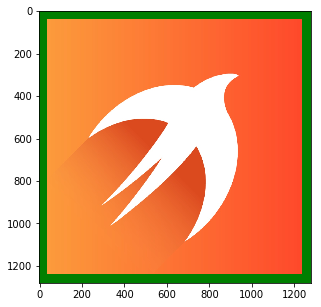

In [ ]:
show_img(
    copyMakeBorder(cvImg, nil, 40, 40, 40, 40, BorderType.BORDER_CONSTANT, RGBA(0, 127, 0, 0))
)

#### Blur

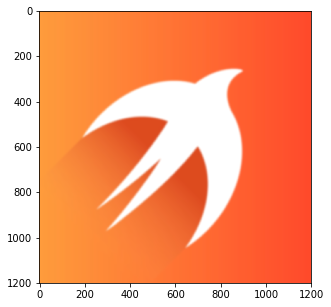

In [ ]:
show_img(
    GaussianBlur(cvImg, nil, Size(25, 25))
)

#### Flip

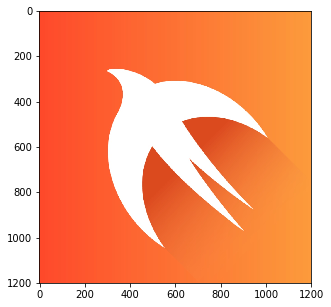

In [ ]:
show_img(
    flip(cvImg, nil, FlipMode.HORIZONTAL)
)

#### Transpose

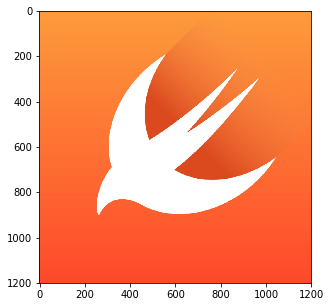

In [ ]:
show_img(
    transpose(cvImg, nil)
)